In [4]:
import os, cv2, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping

2025-08-10 12:10:49.943433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754827850.123420      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754827850.174921      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


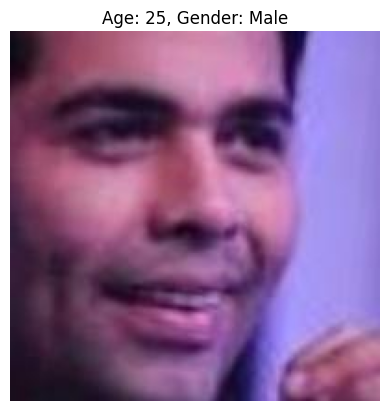

File: 25_0_3_20170119171302287.jpg.chip.jpg
Age: 25
Gender: Male


In [5]:
DATASET_DIR = "/kaggle/input/utkface-new/UTKFace"

file_list = [
    os.path.join(DATASET_DIR, f)
    for f in os.listdir(DATASET_DIR)
    if f.lower().endswith(".jpg")
]

random_file = random.choice(file_list)
parts = os.path.basename(random_file).split("_")
age = int(parts[0])
gender = "Male" if int(parts[1]) == 0 else "Female"

img = cv2.imread(random_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(f"Age: {age}, Gender: {gender}")
plt.axis('off')
plt.show()

print(f"File: {os.path.basename(random_file)}")
print(f"Age: {age}")
print(f"Gender: {gender}")

In [ ]:
male_count = 0
female_count = 0

for filename in os.listdir(DATASET_DIR):
    if filename.endswith(".jpg"):
        try:
            gender = int(filename.split("_")[1])
            if gender == 0:
                male_count += 1
            elif gender == 1:
                female_count += 1
        except:
            continue
print(f"Tổng số ảnh: {male_count + female_count}")
print(f"Số nam   : {male_count}")
print(f"Số nữ    : {female_count}")

labels = ['Male', 'Female']
counts = [male_count, female_count]

plt.bar(labels, counts, color=['blue', 'pink'])
plt.title("Gender Distribution in UTKFace")
plt.ylabel("Số lượng ảnh")
plt.show()

In [ ]:
ages = []

for filename in os.listdir(DATASET_DIR):
    if filename.endswith(".jpg"):
        try:
            age = int(filename.split("_")[0])
            ages.append(age)
        except:
            continue  # bỏ qua file lỗi

plt.figure(figsize=(10, 5))
plt.hist(ages, bins=range(0, 101, 5), color='skyblue', edgecolor='black')
plt.title("Phân bố tuổi trong UTKFace")
plt.xlabel("Tuổi")
plt.ylabel("Số lượng ảnh")
plt.grid(True)
plt.xticks(range(0, 101, 5))
plt.show()

In [ ]:
train_files, temp_files = train_test_split(file_list, test_size=0.3, random_state=42)

val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

print(f"Tổng ảnh     : {len(file_list)}")
print(f"Train ảnh    : {len(train_files)}")
print(f"Validation ảnh: {len(val_files)}")
print(f"Test ảnh     : {len(test_files)}")

In [ ]:
MAX_AGE = 116

def load_and_preprocess(file_name, img_size=128):
    file_path = os.path.join(DATASET_DIR, file_name)
    img = cv2.imread(file_path)
    if img is None:
        raise ValueError(f"Không đọc được file ảnh: {file_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # đổi BGR sang RGB
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype(np.float32)
    return img


def extract_labels_from_filename(file_path):
    # filename có dạng: age_gender_race_date.jpg.chip.jpg
    base = os.path.basename(file_path)
    parts = base.split('_')
    age = int(parts[0])
    gender = int(parts[1])  # 0 = Male, 1 = Female
    age = age / MAX_AGE
    return gender, age

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datagen(augment=False):
    if augment:
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            fill_mode='nearest'
        )
    else:
        return ImageDataGenerator(rescale=1./255)

train_datagen = create_datagen(augment=True)
val_datagen = create_datagen(augment=False)

In [ ]:
def multi_output_generator(file_list, datagen, batch_size=32, img_size=128, shuffle=True):
    while True:
        if shuffle:
            random.shuffle(file_list)
        for i in range(0, len(file_list), batch_size):
            batch_files = file_list[i:i+batch_size]
            batch_images = []
            gender_labels = []
            age_labels = []

            for file in batch_files:
                img = load_and_preprocess(file, img_size)
                gender, age = extract_labels_from_filename(file)
                batch_images.append(img)
                gender_labels.append(gender)
                age_labels.append(age)

            batch_images = np.array(batch_images)

            batch_images_aug_iter = datagen.flow(batch_images, batch_size=len(batch_images), shuffle=False)
            batch_images_aug = next(batch_images_aug_iter)

            yield batch_images_aug, {
                'gender_output': np.array(gender_labels),
                'age_output': np.array(age_labels, dtype=np.float32)
            }

In [8]:
import tensorflow as tf

MAX_AGE = 116

def extract_labels_from_filename(file_path):
    base = tf.strings.split(file_path, os.sep)[-1]
    parts = tf.strings.split(base, '_')
    age = tf.strings.to_number(parts[0], out_type=tf.float32) / MAX_AGE
    gender = tf.strings.to_number(parts[1], out_type=tf.float32)
    return gender, age

def load_and_preprocess(file_path, img_size=128):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    gender, age = extract_labels_from_filename(file_path)
    return img, {'gender_output': gender, 'age_output': age}

def augment(img, labels):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    img = tf.image.random_saturation(img, lower=0.9, upper=1.1)
    img = tf.image.random_hue(img, max_delta=0.02)
    return img, labels

def create_dataset(file_list, batch_size=64, augment_data=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(file_list))
    ds = ds.map(lambda x: load_and_preprocess(x, 128), num_parallel_calls=tf.data.AUTOTUNE)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Thay thế train_gen / val_gen
train_gen = create_dataset(train_files, batch_size=64, augment_data=True, shuffle=True)
val_gen = create_dataset(val_files, batch_size=64, augment_data=False, shuffle=False)

NameError: name 'train_files' is not defined

In [ ]:
# train_gen = multi_output_generator(train_files, train_datagen, batch_size=32, img_size=128, shuffle=True)
# val_gen = multi_output_generator(val_files, val_datagen, batch_size=32, img_size=128, shuffle=False)

In [ ]:
def build_model(base_model_class, pooling_mode='avg'):
    if pooling_mode == 'flatten':
        base_model = base_model_class(
            include_top=False,
            input_shape=(128, 128, 3),
            weights='imagenet'
        )
        x = layers.Flatten()(base_model.output)
    else:
        base_model = base_model_class(
            include_top=False,
            input_shape=(128, 128, 3),
            pooling=pooling_mode,
            weights='imagenet'
        )
        x = base_model.output

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)
    age_output = layers.Dense(1, activation='linear', name='age_output')(x)

    model = Model(inputs=base_model.input, outputs=[gender_output, age_output])
    model.compile(
        optimizer='adam',
        loss={
            'gender_output': 'binary_crossentropy',
            'age_output': 'mse'
        },
        metrics={
            'gender_output': 'accuracy',
            'age_output': 'mae'
        }
    )
    return model

def train_and_save(model, name, train_gen, val_gen, output_dir="/kaggle/working"):
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=29,
        restore_best_weights=True
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30,
        callbacks=[early_stop],
        verbose=1
    )

    pd.DataFrame(history.history).to_csv(f"{output_dir}/{name}_history.csv", index=False)
    model.save(f"{output_dir}/{name}_model.h5")
    print(f"✅ {name} đã lưu model & history.")


In [ ]:
print("===== Training ResNet50 =====")
model_resnet = build_model(ResNet50, pooling_mode='avg')
train_and_save(model_resnet, "ResNet50", train_gen, val_gen)

In [ ]:
print("===== Training VGG16 =====")
model_vgg = build_model(VGG16, pooling_mode='flatten')
train_and_save(model_vgg, "VGG16", train_gen, val_gen)

In [ ]:
print("===== Training EfficientNetB0 =====")
model_eff = build_model(EfficientNetB0, pooling_mode='avg')
train_and_save(model_eff, "EfficientNetB0", train_gen, val_gen)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# File paths
files = {
    "EfficientNetB0": "/kaggle/input/my-results/EfficientNetB0_history.csv",
    "ResNet50": "/kaggle/input/my-results/ResNet50_history.csv",
    "VGG16": "/kaggle/input/my-results/VGG16_history.csv"
}

# Thư mục lưu ảnh
save_dir = "./plots"
os.makedirs(save_dir, exist_ok=True)

for name, path in files.items():
    df = pd.read_csv(path)
    
    # ---- Plot Accuracy ----
    plt.figure(figsize=(8, 5))
    plt.plot(df['gender_output_accuracy'], label='Train Acc')
    plt.plot(df['val_gender_output_accuracy'], linestyle='--', label='Val Acc')
    plt.title(f'{name} - Gender Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{name}_accuracy.png"))
    plt.close()
    
    # ---- Plot Loss ----
    plt.figure(figsize=(8, 5))
    plt.plot(df['loss'], label='Train Loss')
    plt.plot(df['val_loss'], linestyle='--', label='Val Loss')
    plt.title(f'{name} - Overall Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{name}_loss.png"))
    plt.close()

print(f"✅ Đã lưu biểu đồ vào thư mục: {save_dir}")


✅ Đã lưu biểu đồ vào thư mục: ./plots


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# File paths
files = {
    "EfficientNetB0": "/kaggle/input/my-results/EfficientNetB0_history.csv",
    "ResNet50": "/kaggle/input/my-results/ResNet50_history.csv",
    "VGG16": "/kaggle/input/my-results/VGG16_history.csv"
}

# Thư mục lưu ảnh
save_dir = "./plots_compare"
os.makedirs(save_dir, exist_ok=True)

# Load dữ liệu
histories = {name: pd.read_csv(path) for name, path in files.items()}

# ==== Train Accuracy ====
plt.figure(figsize=(8, 5))
for name, df in histories.items():
    plt.plot(df['gender_output_accuracy'], label=name)
plt.title("Train Accuracy (Gender)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "train_accuracy.png"))
plt.close()

# ==== Val Accuracy ====
plt.figure(figsize=(8, 5))
for name, df in histories.items():
    plt.plot(df['val_gender_output_accuracy'], label=name)
plt.title("Validation Accuracy (Gender)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "val_accuracy.png"))
plt.close()

# ==== Train Loss ====
plt.figure(figsize=(8, 5))
for name, df in histories.items():
    plt.plot(df['loss'], label=name)
plt.title("Train Loss (Overall)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "train_loss.png"))
plt.close()

# ==== Val Loss ====
plt.figure(figsize=(8, 5))
for name, df in histories.items():
    plt.plot(df['val_loss'], label=name)
plt.title("Validation Loss (Overall)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "val_loss.png"))
plt.close()

print(f"✅ Đã lưu các biểu đồ so sánh vào thư mục: {save_dir}")

✅ Đã lưu các biểu đồ so sánh vào thư mục: ./plots_compare


In [18]:
import tensorflow as tf
import os

MAX_AGE = 116  # scale lại MAE tuổi

DATASET_DIR = "/kaggle/input/utkface-new/UTKFace"
model_paths = {
    "EfficientNetB0": "/kaggle/input/my-results/EfficientNetB0_model.h5",
    "ResNet50": "/kaggle/input/my-results/ResNet50_model.h5",
    "VGG16": "/kaggle/input/my-results/VGG16_model.h5"
}

# Lấy danh sách file test
test_files = [
    os.path.join(DATASET_DIR, f)
    for f in os.listdir(DATASET_DIR)
    if f.lower().endswith(".jpg")
]

# Hàm create_dataset bạn đã có sẵn
test_gen = create_dataset(test_files, batch_size=64, augment_data=False, shuffle=False)

# Load custom loss/metrics khi mở model
custom_objects = {
    "mse": tf.keras.losses.MeanSquaredError(),
    "mae": tf.keras.losses.MeanAbsoluteError()
}

for name, model_path in model_paths.items():
    print(f"🔍 Đang đánh giá {name}...")
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    results = model.evaluate(test_gen, verbose=1)
    print("Test loss and metrics:", results)


🔍 Đang đánh giá EfficientNetB0...
371/371 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - age_output_loss: 0.0243 - age_output_mean_absolute_error: 0.1164 - gender_output_accuracy: 0.7966 - gender_output_loss: 0.4385 - loss: 0.4628
Test loss and metrics: [0.4640033543109894, 0.4398691952228546, 0.024005640298128128, 0.11607392877340317, 0.7962291240692139]
🔍 Đang đánh giá ResNet50...
371/371 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - age_output_loss: 0.0100 - age_output_mean_absolute_error: 0.0784 - gender_output_accuracy: 0.9414 - gender_output_loss: 0.1486 - loss: 0.1586
Test loss and metrics: [0.16278740763664246, 0.15308408439159393, 0.00978559534996748, 0.07761602848768234, 0.9399358630180359]
🔍 Đang đánh giá VGG16...
371/371 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - age_output_loss: 0.0171 - age_output_mean_absolute_error: 0.0980 - gender_output_accuracy: 0.9114 - gender_output_loss: 0.2074 - loss: 0.2245
Test loss and metrics: [0.22372928261756897, 0.20685997605323792, 0.016798432916402817, 0.097344